In [1]:
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
from numpy import loadtxt
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras import layers
# import keras
import sklearn.preprocessing as sk
import math

In [2]:
bus = 57



data_x = loadtxt(('data_x_pf_%d.csv' %bus), delimiter=',')
data_y = loadtxt(('data_y_%d.csv' %bus), delimiter=',')

# Load data from csv into variables
# with open('data_x_pf_%d.csv' %bus) as xcvs:
#     readCSV = csv.reader(xcvs, delimiter=',')
#     data_x = np.ones([bus*3,sample])
#     i = 0
#     for row in readCSV:
#         data_x[i,:] = row
#         i = i+1
        
# with open('data_y_%d.csv' %bus) as ycvs:
#     readCSV = csv.reader(ycvs, delimiter=',')
#     data_y = np.ones([bus*2,sample])
#     i = 0
#     for row in readCSV:
#         data_y[i,:] = row
#         i = i+1        
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
print(device)

cuda:0


In [3]:
# Separate generate data into  training, val, test data set
# data_y = data_y[0:bus,:]          #Remove data for bus angle
data_y = data_y[bus:bus*2,:]        #Remove data for voltage magnitude
lenx , sample = data_x.shape
leny , sample = data_y.shape
sample = 10000
num1 = int(0.8*sample)
num2 = int(0.1*sample)
ref_bus = np.nonzero(np.mean(data_y,1) == 0)

# train_x = torch.Tensor(data_x[:,0:num1]).transpose(0, 1)
# val_x   = torch.Tensor(data_x[:,num1:(num1+num2)]).transpose(0, 1)
# test_x  = torch.Tensor(data_x[:,(num1+num2):sample]).transpose(0, 1)

# train_y = torch.Tensor(data_y[bus:bus*2,0:num1]).transpose(0, 1)
# val_y   = torch.Tensor(data_y[bus:bus*2,num1:(num1+num2)]).transpose(0, 1)
# test_y  = torch.Tensor(data_y[bus:bus*2,(num1+num2):sample]).transpose(0, 1)

nrbus = bus

In [4]:
# Identify reference bus and remove it from output training data set
nrbus = bus-1
data_y = np.delete(data_y,ref_bus,0)

# Convert angles from degrees to radians
data_y = data_y + 360
data_y = (data_y * math.pi)/180

print(ref_bus)
print(data_y.shape)

(array([0], dtype=int64),)
(56, 50000)


In [5]:
def sort_data(data_set,num_1,num_2,size):
    lendat , sample = data_set.shape
    data = torch.Tensor(data_set[:,num_1:num_2]).transpose(0, 1)
    data = data.reshape(data.shape[0],int(lendat/size),size).to(device) 
    data = data.transpose(1,2)
    return data

In [6]:
train_x = sort_data(data_x,0,num1,bus)
val_x   = sort_data(data_x,num1,num1+num2,bus)
test_x  = sort_data(data_x,num1+num2,sample,bus)

train_y = sort_data(data_y,0,num1,nrbus)
val_y   = sort_data(data_y,num1,num1+num2,nrbus)
test_y  = sort_data(data_y,num1+num2,sample,nrbus)

In [7]:
# Normalize the data into range between -1 and 1

# def normalize(data):
#     x , y , z = data.shape
#     max_val = torch.reshape(torch.amax(torch.abs(data),1),(x,1,z))
#     max_val = torch.amax(torch.amax(torch.abs(data),1),0)
#     norm = torch.divide(data,max_val).transpose(1,2)
#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
#     return norm, max_val

def y_norm_train(data):
    x , y , z = data.shape    
    
    # Turn data points into z-score
    mean_val = torch.mean(torch.mean(data,1),0)
    std_val = torch.std(torch.std(data,1),0)
    data = torch.divide(data - mean_val,std_val)
    
    # Normalize data between 0.9 and 1
    min_val = torch.amin(torch.amin(data,1),0)
    max_val = torch.amax(torch.amax(data,1),0)    
    norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
    norm = norm*0.1 + 0.9
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, max_val, min_val, mean_val, std_val

def y_norm_eval(data,max_val,min_val,mean_val,std_val):
    x , y , z = data.shape
    
    data = torch.divide(data - mean_val,std_val)
    norm = torch.divide(data-min_val,max_val-min_val).transpose(1,2)
    norm = norm*0.1 + 0.9
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm


def norm_train(data):
    x , y , z = data.shape
    max_val = torch.amax(torch.amax(torch.abs(data),1),0)
    norm = torch.divide(data,max_val).transpose(1,2)    
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm, max_val

def norm_eval(data,max_val):
    x , y , z = data.shape
    norm = torch.divide(data,max_val).transpose(1,2) 
    norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)
    return norm


# def normalize(data):
#     x , y , z = data.shape
#     norm = data
#     for i in range(0,z,1):
#         temp = data[:,:,i].squeeze()
# #         norm[:,:,i] = torch.Tensor(sk.quantile_transform(temp.cpu(), axis=0, n_quantiles=1000, output_distribution='uniform', ignore_implicit_zeros=False, subsample=100000, random_state=100, copy=True))
#         norm[:,:,i] = torch.Tensor(sk.maxabs_scale(temp.cpu(), axis=0, copy=True))

#     norm = norm.reshape(-1,y*z)      #Reshape data into shape (sample, bus*column)    
#     return norm

# preprocessing.power_transform(X, method='yeo-johnson', *, standardize=True, copy=True)

In [8]:
min_val = torch.amin(torch.amin(train_x,1),0)
max_val = torch.amax(torch.amax(train_x,1),0)    
norm = torch.divide(train_x-min_val,max_val-min_val)
print(norm[1,:,:])
print(train_x[1,:,:])

tensor([[0.4561, 0.3087, 0.8214],
        [0.2802, 0.0179, 0.4360],
        [0.2847, 0.3578, 0.6228],
        [0.2871, 0.4660, 0.2308],
        [0.2611, 0.4461, 0.1235],
        [0.1161, 0.4601, 0.7103],
        [0.2871, 0.4660, 0.9497],
        [0.9497, 0.6659, 0.3288],
        [0.0324, 0.3462, 0.7194],
        [0.2759, 0.4566, 0.1621],
        [0.2871, 0.4660, 0.7799],
        [0.1039, 0.9722, 0.1390],
        [0.2448, 0.4555, 0.0104],
        [0.2632, 0.4384, 0.8189],
        [0.2418, 0.4429, 0.2150],
        [0.1978, 0.4503, 0.6523],
        [0.1942, 0.4266, 0.7736],
        [0.2288, 0.4206, 0.7227],
        [0.2804, 0.4632, 0.8572],
        [0.2819, 0.4610, 0.1976],
        [0.2871, 0.4660, 0.4946],
        [0.2871, 0.4660, 0.1196],
        [0.2727, 0.4560, 0.6336],
        [0.2871, 0.4660, 0.7907],
        [0.2744, 0.4508, 0.5492],
        [0.2871, 0.4660, 0.0395],
        [0.2685, 0.4636, 0.1706],
        [0.2767, 0.4550, 0.7351],
        [0.2514, 0.4538, 0.7213],
        [0.279

In [9]:
# Training model

class PowerFlow(nn.Module):
    def __init__(self):
        super(PowerFlow,self).__init__()
        #layer definitions
#         self.FC1   = nn.Linear(bus*3,500)
#         self.FC2   = nn.Linear(500,100)
#         self.FC3   = nn.Linear(100,50)
#         self.FC4   = nn.Linear(50,branch)
#         self.act   = nn.LeakyReLU(0.3)

        self.FC1   = nn.Linear(lenx,500)
        self.FC2   = nn.Linear(500,1000)
        self.FC3   = nn.Linear(1000,800)
        self.FC4   = nn.Linear(800,600)
        self.FC5   = nn.Linear(600,400)
        self.FC6   = nn.Linear(400,200)
        self.FC7   = nn.Linear(200,nrbus)
        self.act1   = nn.LeakyReLU(0.3)
        self.act2   = nn.LeakyReLU(0.4)


    def forward(self, x):
        x = self.act1(self.FC1(x))
        x = self.act1(self.FC2(x))
        x = self.act1(self.FC3(x))
        x = self.act2(self.FC4(x))
        x = self.act2(self.FC5(x))
        x = self.act2(self.FC6(x))
        x = self.FC7(x)
        return x
    
# Loss function
def MSE(ypred,ytrue):
    loss = nn.MSELoss()
#     loss = nn.L1Loss()
    return loss(ypred,ytrue)

def abs_error(ypred,ytrue,ref):
    error = 2 * torch.abs(ypred - ytrue) / torch.abs(ypred + ytrue)
#     error = torch.abs(ypred - ytrue)/ torch.abs(ytrue)
#     error[ytrue == 0] = torch.abs(ypred[ytrue == 0])
    mean_error = torch.mean(error)*100
    return mean_error.detach().cpu().numpy()
    

In [10]:
# n = 0
# num_epochs  = 1000
# batch = 250
# iter = int(num1/batch)
# disp = 4

# # physical_devices = tf.config.list_physical_devices('GPU') 
# # tf.config.experimental.set_memory_growth(physical_devices[0], True)

# norm_train_x, max_train_x = norm_train(train_x)
# norm_train_y, max_train_y = norm_train(train_y)
# norm_val_x = norm_eval(val_x, max_train_x)
# norm_val_y = norm_eval(val_y, max_train_y)


# #      self.FC1   = nn.Linear(bus*3,500)
# #         self.FC2   = nn.Linear(500,1000)
# #         self.FC3   = nn.Linear(1000,800)
# #         self.FC4   = nn.Linear(800,600)
# #         self.FC5   = nn.Linear(600,400)
# #         self.FC6   = nn.Linear(400,200)
# #         self.FC7   = nn.Linear(200,bus)
# #         self.act1   = nn.LeakyReLU(0.3)
# #         self.act2   = nn.LeakyReLU(0.4)
# norm_train_x = norm_train_x.cpu().numpy()
# norm_train_y = norm_train_y.cpu().numpy()

# act1 = keras.layers.LeakyReLU(alpha=0.3)
# act2 = keras.layers.LeakyReLU(alpha=0.4)
        
# NNPF = Sequential()
  
# NNPF.add(Dense(500, input_dim=bus*3, activation='sigmoid'))
# NNPF.add(Dense(1000, activation='sigmoid'))
# NNPF.add(Dense(800, activation='sigmoid'))
# NNPF.add(Dense(600, activation='sigmoid'))
# NNPF.add(Dense(400, activation='sigmoid'))
# NNPF.add(Dense(200, activation='sigmoid'))
# NNPF.add(Dense(bus))

# # compile the keras model
# NNPF.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# # fit the keras model on the dataset
# NNPF_result = NNPF.fit(x = norm_train_x, y = norm_train_y, epochs=1000, batch_size=200, validation_data=(norm_val_x, norm_val_y))

In [11]:
# norm_train_x, max_train_x, min_train_x = norm_train(train_x)
norm_train_y, max_train_y, min_train_y, mean_train_y, std_train_y = y_norm_train(train_y)
# norm_val_x = norm_eval(val_x, max_train_x, min_train_x)
norm_val_y = y_norm_eval(val_y, max_train_y, min_train_y, mean_train_y, std_train_y)

norm_train_x, max_train_x = norm_train(train_x)
# norm_train_y, max_train_y = norm_train(train_y)
norm_val_x = norm_eval(val_x, max_train_x)
# norm_val_y = norm_eval(val_y, max_train_y)

# norm_train_x = normalize(train_x)
# norm_train_y = normalize(train_y)
# norm_val_x   = normalize(val_x)
# norm_val_y   = normalize(val_y)


In [12]:
# Define training variables

CNNPF = PowerFlow().to(device)
optimizer = optim.SGD(CNNPF.parameters(), lr=0.0001, momentum=0.7)
# optimizer = optim.Adam(CNNPF.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.1, amsgrad=False)
hloss = []
train_err = []
val_err = []
n = 0
num_epochs  = 2000
batch = 250
iter = int(num1/batch)
disp = 10



# Start training
CNNPF = CNNPF.train()

for epoch in range(num_epochs):
    index = np.random.choice(num1, batch*iter, replace=False)
    index = np.reshape(index,[iter,batch])
    
    for i in range(iter):
        CNNPF = CNNPF.train()
        X = norm_train_x[index[i,:],:]     
        Y = norm_train_y[index[i,:],:]
        
        optimizer.zero_grad()

        # Forward + backward + optimize
        Y_pred = CNNPF(X)
        loss = MSE(Y_pred,Y)
        loss.backward()
        optimizer.step()
        n += 1
        
    if epoch % disp == 0:
    
        hloss.append(loss.detach().cpu().numpy()) 
        CNNPF = CNNPF.eval()
        pred_y = CNNPF(norm_val_x).detach()
        error = abs_error(pred_y,norm_val_y,ref_bus)
        val_err.append(error) 

        pred_y = CNNPF(norm_train_x).detach()
        error = abs_error(pred_y,norm_train_y,ref_bus)
        train_err.append(error)        

        print(loss.detach().cpu().numpy(), error) 


0.88315165 198.6184
0.87379056 196.48305
0.8639046 194.38103
0.8547589 192.29694
0.8454651 190.23398
0.83603805 188.2046
0.8271812 186.19754
0.8180907 184.20308
0.808793 182.22307
0.7994845 180.2606
0.79063827 178.32408
0.7815251 176.39131
0.77259153 174.45953
0.7632493 172.53185
0.754356 170.60037
0.74512404 168.66393
0.7357899 166.71674
0.72640365 164.75327
0.7167789 162.77118
0.70683146 160.76738
0.6971508 158.73738
0.6869992 156.67885
0.67706823 154.58463
0.6664566 152.45364
0.6556382 150.27446
0.6444537 148.03384
0.6329334 145.72223
0.6208234 143.33308
0.608264 140.8541
0.5952642 138.27293
0.5815345 135.56847
0.5670939 132.70462
0.55141604 129.67166
0.5347459 126.43702
0.51676744 122.95447
0.49701735 119.167244
0.47532108 115.00615
0.45130467 110.37784
0.4238148 105.16203
0.39264643 99.20805
0.3568738 92.33515
0.31526625 84.32902
0.2671921 74.96005
0.21365607 64.13507
0.15699936 52.05223
0.1036623 39.43848
0.06138635 27.636328
0.03443232 18.525795
0.020172527 13.233744
0.013168891

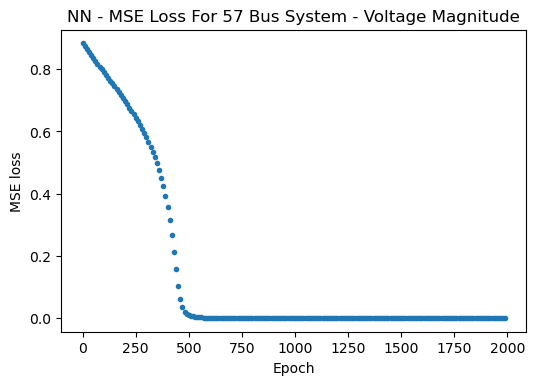

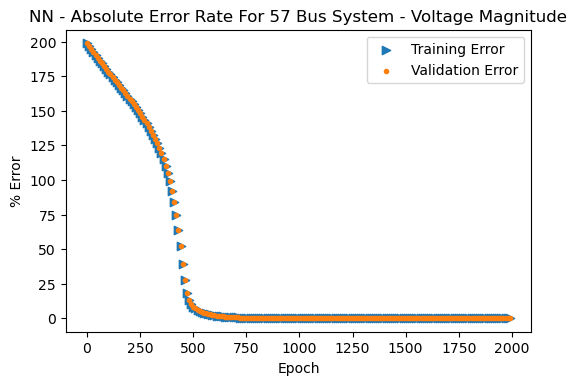

In [13]:
# Plot the result  
plt.figure(dpi=100)       
plt.scatter(range(0,num_epochs,disp),hloss,marker=".")
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('NN - MSE Loss For {} Bus System - Voltage Magnitude'.format(bus))
plt.savefig("Graph_NN/NN_Loss_V_{}.png".format(bus))

plt.figure(dpi=100) 
plt.scatter(range(0,num_epochs,disp),train_err, label = "Training Error",marker=">")
plt.scatter(range(0,num_epochs,disp),val_err, label = 'Validation Error',marker=".")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("% Error")
plt.title('NN - Absolute Error Rate For {} Bus System - Voltage Magnitude'.format(bus))
plt.savefig("Graph_NN/NN_Error_V_{}.png".format(bus))

In [14]:
Y = Y.reshape(batch,nrbus,1)
Y_pred = Y_pred.reshape(batch,nrbus,1)
print(Y[8,:].detach().cpu().numpy())
print(Y_pred[8,:].detach().cpu().numpy())
# print(norm_train_y[7,25].detach().cpu().numpy())

[[0.9997583 ]
 [0.9760545 ]
 [0.9693204 ]
 [0.9637392 ]
 [0.96345013]
 [0.96884215]
 [0.9848001 ]
 [0.9591787 ]
 [0.9487063 ]
 [0.955253  ]
 [0.9534067 ]
 [0.95670223]
 [0.9587222 ]
 [0.9694867 ]
 [0.96157616]
 [0.977774  ]
 [0.946121  ]
 [0.93851644]
 [0.93731594]
 [0.94036144]
 [0.94068027]
 [0.94035816]
 [0.93848485]
 [0.9130827 ]
 [0.9401418 ]
 [0.9484908 ]
 [0.95399874]
 [0.9578134 ]
 [0.91032165]
 [0.9064236 ]
 [0.91124475]
 [0.9110442 ]
 [0.9338302 ]
 [0.9351671 ]
 [0.9367079 ]
 [0.9377057 ]
 [0.9413826 ]
 [0.9375051 ]
 [0.93666923]
 [0.9352646 ]
 [0.92787325]
 [0.9492953 ]
 [0.9458334 ]
 [0.9590688 ]
 [0.9495827 ]
 [0.9424503 ]
 [0.9419693 ]
 [0.9402387 ]
 [0.93768513]
 [0.94315624]
 [0.9494912 ]
 [0.94584423]
 [0.9486055 ]
 [0.95316404]
 [0.92485243]
 [0.9223266 ]]
[[0.9976374 ]
 [0.9729412 ]
 [0.9655802 ]
 [0.9594613 ]
 [0.95891035]
 [0.9644242 ]
 [0.9808407 ]
 [0.9542244 ]
 [0.94415855]
 [0.9508443 ]
 [0.94886726]
 [0.9526049 ]
 [0.9550084 ]
 [0.9660667 ]
 [0.957412  ]
 [0.9

In [15]:
# Start eval
CNNPF = CNNPF.eval()

norm_test_x = norm_eval(test_x, max_train_x)
norm_test_y = y_norm_eval(test_y, max_train_y, min_train_y, mean_train_y, std_train_y)

pred_y = CNNPF(norm_test_x)
error = abs_error(pred_y,norm_test_y,ref_bus)
print(error)

0.26774982


In [16]:
# mean_data = torch.mean(torch.mean(train_y,1),0)
# std_data = torch.std(torch.std(train_y,1),0)
# z_y = torch.divide(train_y - mean_data,std_data)

# print(mean_data)
# print(std_data)
# print(z_y[1,:,:])
# print(torch.min(z_y))

# print(z_y.shape)
# print(train_y.shape)
# norm_z_y, max_z_y, min_z_y = y_norm_train(z_y)
# print(torch.min(norm_z_y))

In [17]:
def denorm_y(norm, max_val, min_val, mean_val, std_val):
    norm = (norm - 0.9) * 10
    data = torch.multiply(norm,max_val-min_val)
    data = data + min_val
    data = torch.multiply(data,std_val) + mean_val    
    data = data.transpose(0,1).detach().cpu().numpy()       
    data = (data * 180) / math.pi
    data = data - 360
    return data 

In [18]:
pred = denorm_y(pred_y,max_train_y, min_train_y, mean_train_y, std_train_y)
test = denorm_y(norm_test_y,max_train_y, min_train_y, mean_train_y, std_train_y)


error = 2 * np.abs((test-pred)) / np.abs((test+pred))
norm_error = 2 * torch.abs((norm_test_y-pred_y)) / torch.abs((norm_test_y+pred_y))


print(np.mean(error)*100)
print(abs_error(pred_y,norm_test_y,ref_bus))




5.124800652265549
0.26774982


In [19]:
print(test[:,0])
print(pred[:,0])

new = 2 * np.abs((test[:,0]-pred[:,0])) / np.abs((test[:,0]+pred[:,0]))
# print(train_y[0,:])
print((train_y[0,:]*180/math.pi)-360)

[ -0.97042847  -5.0983887   -6.227844    -7.128479    -7.1744385
  -6.293915    -3.5552368   -8.040039    -9.916565    -8.715668
  -9.214508    -8.486969    -8.09317     -6.200592    -7.8240356
  -4.6992188  -10.270538   -11.4878845  -11.650299   -11.182739
 -11.138367   -11.196869   -11.473999   -15.540222   -11.199493
  -9.792816    -8.85672     -8.2092285  -15.947968   -16.41809
 -15.773254   -15.808899   -12.215424   -12.003754   -11.768097
 -11.611755   -11.014221   -11.649933   -11.779999   -12.025177
 -13.37973     -9.719086   -10.228516    -7.972229    -9.640442
 -10.849731   -10.926849   -11.21814    -11.585083   -10.86792
  -9.778534   -10.47229     -9.921112    -9.096741   -13.885498
 -14.369019  ]
[ -0.19229126  -4.334839    -5.411804    -6.4871216   -6.546875
  -5.6795044   -2.9342651   -7.423126    -9.12265     -8.0043335
  -8.203369    -7.6647034   -7.313965    -5.3841553   -6.9605103
  -3.8243408   -9.305634   -10.605225   -10.857391   -10.395111
 -10.292267   -10.34573

In [20]:
with open(("Result/V_{}_Bus_Predict.csv".format(bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(nrbus):
        csv_writer.writerow(pred[i,:])
        
with open(("Result/V_{}_Bus_Test.csv".format(bus)), 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i in range(nrbus):
        csv_writer.writerow(test[i,:])